In [1]:
# base imports, these should always work

# be sure that torch geometric works... if not install with pip (CPU version is good enough...):

# pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
# pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
# pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
# pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
# pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
# pip install torch-geometric

import os
import torch
import numpy as np
from copy import deepcopy

from scipy.sparse import save_npz
from scipy.sparse import load_npz

import pandas as pd

import networkx as nx

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import KernelPCA, TruncatedSVD, PCA
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score, pairwise_distances
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, svm, metrics

## change directory to ./tudataset/tud_benchmark for imports, then back to base directory

In [2]:
# we set our working dir to the tud_benchmark directory, here are the necessary 
# python files for the include below
os.chdir("./tudataset/tud_benchmark")
import auxiliarymethods
from auxiliarymethods import datasets as dp
from auxiliarymethods import auxiliary_methods as aux
from auxiliarymethods import kernel_evaluation
from auxiliarymethods import reader
os.chdir("../..")

## this part requires the Python bindings for the C++ baseline WL kernels

## The following cells are only required for the recalculation of the baseline Gram matrices / sparse vectors, otherwise don't execute cells below.

In [5]:
# Compile kernel_baselines.cpp once...
# ./tudataset/tud_benchmark/kernel_baselines

# see generate_kernels.ipynb for more detail, dont launch this here...

# also requires pybind, eigen3... Linux commands:

# sudo apt-get install libeigen3-dev
# sudo apt install python3-pybind11
# g++ -I /usr/include/eigen3 -O3 -shared -std=c++11 -fPIC `python3 -m pybind11 --includes`  kernel_baselines.cpp src/*cpp -o ../kernel_baselines`python3-config --extension-suffix`

In [3]:
# include the compiled Python bindings:
os.chdir("./tudataset/tud_benchmark")
import kernel_baselines as kb
os.chdir("../..")

In [4]:
# !! no necessity to call this...

# this regenerates the baseline kernels and saves the gram matrices & sparse vectors 
# under ./tudataset/tud_benchmark/kernels/

use_edge_labels = False
dataset = "ENZYMES"

os.chdir("./tudataset/tud_benchmark")
for use_labels in [True, False]:# Except IMDB-BINARY

        if use_labels:
            base_path = os.path.join("kernels","node_labels")
        else:
            base_path = os.path.join("kernels","without_labels")
            
        print("Start processing data set ", dataset)
        # Download dataset.
        classes = dp.get_dataset(dataset)
        # *Weisfeihler-Lehman*
        print("Start computing Weisfeihler-Lehman gram matrix and vector representations")
        
        iterations = 6 # means just 5...
        
        #0 taking just the nodelabels themselves into account; 
        #1 considers nearest-neighbours, 2 one layer deeper and so on
        for i in range(1, iterations):
            print("Start iteration ", i)
            #Gram Matrix for the Weisfeiler-Lehman subtree kernel
            gram_matrix_wl = kb.compute_wl_1_dense(dataset, i, use_labels, use_edge_labels)
            np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_wl{i}.csv"),
                    gram_matrix_wl,
                    delimiter=";")
            #Sparse Vectors for the Weisfeiler-Lehmann subtree kernel
            vectors_wl = kb.compute_wl_1_sparse(dataset, i, use_labels, use_edge_labels)
            save_npz(os.path.join(base_path,f"{dataset}_vectors_wl{i}.npz"),
                    vectors_wl, compressed=True)               
            
        # *Graphlet kernel*
        print("Start computing Graphlet gram matrix")

        #Gram Matrix for the Graphlet kernel
        gram_matrix_graphlet= kb.compute_graphlet_dense(dataset, use_labels, use_edge_labels)
        np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_graphlet.csv"),
                gram_matrix_graphlet,
                delimiter=";")

        print("Start computing Graphlet vector representation")
        #Sparse Vectors for the Graphlet kernel
        vectors_graphlet = kb.compute_graphlet_sparse(dataset, use_labels, use_edge_labels)
        save_npz(os.path.join(base_path,f"{dataset}_vectors_graphlet.npz"),
                vectors_graphlet, compressed=True)


        print("Start computing Shortest path gram matrix")
        #Gram Matrix for the Shortest path kernel
        gram_matrix_shortestpath = kb.compute_shortestpath_dense(dataset, use_labels)
        np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_shortestpath.csv"),
                gram_matrix_shortestpath,
                delimiter=";")

        print("Start computing Shortest path vector representation")
        #Sparse Vectors for the Shortest path kernel
        vectors_shortestpath = kb.compute_shortestpath_sparse(dataset, use_labels)
        save_npz(os.path.join(base_path,f"{dataset}_vectors_shortestpath.npz"),
                vectors_shortestpath, compressed=True)
        
        # // Max hinzugefügt
        # Weisfeiler-Lehman optimal assignment kernel
        # *WL-OA* # https://chrsmrrs.github.io/datasets/docs/evaluation/
        print("Start WL OA")
        gram_matrix_oa = kb.compute_wloa_dense(dataset, 6, use_labels, use_edge_labels)    
        np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_oa.csv"),
                gram_matrix_oa,
                delimiter=";")
                   
        # does not exist?
        #   vectors_oa = kb.compute_wloa_sparse(dataset, 6, use_labels, use_edge_labels)
        #   save_npz(os.path.join(base_path,f"{dataset}_vectors_oa.npz"),
        #           vectors_oa, compressed=True)

os.chdir("../..")

Start processing data set  ENZYMES
Start computing Weisfeihler-Lehman gram matrix and vector representations
Start iteration  1
Start iteration  2
Start iteration  3
Start iteration  4
Start iteration  5
Start computing Graphlet gram matrix
Start computing Graphlet vector representation
Start computing Shortest path gram matrix
Start computing Shortest path vector representation
Start WL OA
Start processing data set  ENZYMES
Start computing Weisfeihler-Lehman gram matrix and vector representations
Start iteration  1
Start iteration  2
Start iteration  3
Start iteration  4
Start iteration  5
Start computing Graphlet gram matrix
Start computing Graphlet vector representation
Start computing Shortest path gram matrix
Start computing Shortest path vector representation
Start WL OA


---

## Start here for the the design of our own kernel.

we can use the tudataset functions (auxiliaryfunctions) to generate the 600 graphs from the individual files in 
./tudataset/tud_benchmark/datasets/ENZYMES/ENZYMES/raw


## Starting points: Python graph kernel examples:

https://github.com/reemagit/GraphKernel

https://github.com/jajupmochi/graphkit-learn

https://strawberryfields.ai/photonics/apps/run_tutorial_similarity.html


A Python implementation of a fast approximation of the Weisfeiler-Lehman Graph Kernels:

https://github.com/deeplego/wl-graph-kernels

https://github.com/deeplego/wl-graph-kernels/blob/master/wlkernel/_wlkernel.py

In [5]:
# all the auxiliaryfunctions method take the argument as string, for whatever reason...
dataset = "ENZYMES"

os.chdir("./tudataset/tud_benchmark")
classes = dp.get_dataset(dataset) # this downloads the datasets and stores a list of integers with the true labels
G = reader.tud_to_networkx(dataset)
os.chdir("../..")

print(f"Number of graphs in data set is {len(G)}")

Number of graphs in data set is 600


In [6]:
# from Nikolas notebook

def visualize(G, color=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G,
    pos=nx.spring_layout(G, seed=42),
    with_labels=True,
    node_color=color,
    cmap="Set2")
    plt.show();    

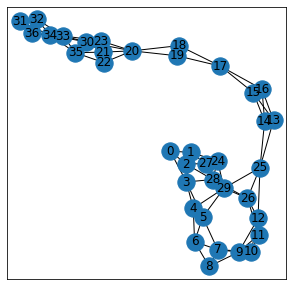

In [7]:
visualize(G[0])

# graph properties:
    # number of nodes and edges
    # degree histogram or distribution
    # node label histogram
    # connectivity
    # planarity
    # bipartitness
    # treewidth

# node properties:
    # centrality measures: eigenvector, pagerank, degree, betweenness, closeness
    # clustering coefficient

---

# Classification Experiments with baseline kernels

load the precomputed Gram matrices as csv. (use subdirectory precomputed_kernels)

Nikola/Peter did some preprocessing, but unprocessed Gram matrices performed better
for SVM tests...

WL Paper: http://www.jmlr.org/papers/volume12/shervashidze11a/shervashidze11a.pdf

WL OA Paper: https://papers.nips.cc/paper/6166-on-valid-optimal-assignment-kernels-and-applications-to-graph-classification.pdf

In [8]:
#Gram Matrix (G=V^T*V) for the Weisfeiler-Lehman subtree kernel

kernel_input_gram = "./precomputed_kernels/node_labels/ENZYMES_gram_matrix_wl1.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_wl1 = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

kernel_input_gram = "./precomputed_kernels/node_labels/ENZYMES_gram_matrix_wl2.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_wl2 = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

kernel_input_gram = "./precomputed_kernels/node_labels/ENZYMES_gram_matrix_wl3.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_wl3 = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

kernel_input_gram = "./precomputed_kernels/node_labels/ENZYMES_gram_matrix_wl4.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_wl4 = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1

kernel_input_gram = "./precomputed_kernels/node_labels/ENZYMES_gram_matrix_wl5.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_wl5 = aux.normalize_gram_matrix(gram_matrix) # values from 0 to 1


### SVM testfunctions by kernel_evaluation.py 

https://scikit-learn.org/stable/modules/multiclass.html <-- !!! good explanation, schöne bilder...

we either use LIBSVM (gram matrices, kernel_svm_evaluation function) or

LIBLINEAR with (optional) edge labels (vectors, function linear_svm_evaluation).

For the enzymes dataset, I think gram matrices are the better choice?

TODO: Other algorithms beside SVM? Accuarcy for all class labels

In [9]:
# the function are in ./tudataset/tud_benchmark/auxiliarymethods/kernel_evaluation.py

# linear_svm_evaluation() uses Kfold crossvalidation with LinearSVC (sklearn) Multiclass as One-Vs-The-Rest
# kernel_svm_evaluation() uses Kfold crossvalidation with SVC (sklearn)       Multiclass as one vs one

# see https://chrsmrrs.github.io/datasets/docs/evaluation/ (SVM evaluation)
# test_size=0.1
# this sets The C parameters (Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
# see https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

# line 98 kernel_evaluation.py: clf = SVC(C=c, kernel="precomputed", tol=0.001)
# !!! we're using the precomputed kernel flag...

all_matrices = [gram_matrix_wl1, gram_matrix_wl2, gram_matrix_wl3, gram_matrix_wl4, gram_matrix_wl5]
num_reps = 10
accuracy, std_10, std_100 = kernel_evaluation.kernel_svm_evaluation(all_matrices, classes, num_repetitions=num_reps, all_std=True)

print ("accuracy:", accuracy)
print ("standard deviations of all 10-CV runs:", std_10) 
print ("standard deviations of all 100 runs:", std_100) 

# this takes a 1 min to compute...

accuracy: 50.38333333333333
standard deviations of all 10-CV runs: 1.2473304828045098
standard deviations of all 100 runs: 6.239902955085831


In [16]:
# Simple SVM SVC setup without cross validation
# this is the approach used in Nikola & Peters exploratory data analysis pdf...
# this might be invalid??

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(gram_matrix_wl5, classes,test_size=0.2,random_state=109) # 70% training and 30% test

# SVM kernels: kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’

clf = svm.SVC(kernel='poly') #Create a svm Classifier, 'poly' kernel is the best by far!

clf.fit(X_train, y_train) #Train the model using the training sets
y_pred = clf.predict(X_test) #Predict the response for test dataset
print(f"Accuracy:", metrics.accuracy_score(y_test,y_pred)) # Model Accuracy: how often is the classifier correct?

Accuracy: 0.6083333333333333


In [11]:
# only using the shortest path kernel & Gram matrix.
# This is __NOT__ the WL shortest path kernel.. sadly

kernel_input_gram = "./precomputed_kernels/node_labels/ENZYMES_gram_matrix_shortestpath.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_shortest_path = aux.normalize_gram_matrix(gram_matrix)

all_matrices = [gram_matrix_shortest_path]
num_reps = 10
accuracy, std_10, std_100 = kernel_evaluation.kernel_svm_evaluation(all_matrices, classes, num_repetitions=num_reps, all_std=True)

print ("accuracy:", accuracy)
print ("standard deviations of all 10-CV runs:", std_10) 
print ("standard deviations of all 100 runs:", std_100) 

# this takes a 30 sec to compute...

accuracy: 40.8
standard deviations of all 10-CV runs: 1.4118545723031584
standard deviations of all 100 runs: 6.816972283287583


In [12]:
# all wl matrices + shortest path 

all_matrices = [gram_matrix_wl1, gram_matrix_wl2, gram_matrix_wl3, gram_matrix_wl4, gram_matrix_wl5, gram_matrix_shortest_path]
num_reps = 10
accuracy, std_10, std_100 = kernel_evaluation.kernel_svm_evaluation(all_matrices, classes, num_repetitions=num_reps, all_std=True)

print ("accuracy:", accuracy)
print ("standard deviations of all 10-CV runs:", std_10) 
print ("standard deviations of all 100 runs:", std_100) 

# this takes about 2 min to compute...

accuracy: 50.43333333333333
standard deviations of all 10-CV runs: 1.2935738607954825
standard deviations of all 100 runs: 6.986574426872029


In [13]:
# only using the "new" WL optimal assignment kernel
# we get the best accuarcy here.

kernel_input_gram = "./precomputed_kernels/node_labels/ENZYMES_gram_matrix_oa.csv"
gram_matrix = np.loadtxt(kernel_input_gram, delimiter=";")
gram_matrix_oa = aux.normalize_gram_matrix(gram_matrix)

all_matrices = [gram_matrix_oa]
num_reps = 10
accuracy, std_10, std_100 = kernel_evaluation.kernel_svm_evaluation(all_matrices, classes, num_repetitions=num_reps, all_std=True)

print ("accuracy:", accuracy)
print ("standard deviations of all 10-CV runs:", std_10) 
print ("standard deviations of all 100 runs:", std_100) 

# this takes a 30 sec to compute...

accuracy: 55.116666666666674
standard deviations of all 10-CV runs: 1.1572236891226653
standard deviations of all 100 runs: 5.926658230215217


In [14]:
# all wl matrices + wl_oa

all_matrices = [gram_matrix_wl1, gram_matrix_wl2, gram_matrix_wl3, gram_matrix_wl4, gram_matrix_wl5, gram_matrix_oa]
num_reps = 10
accuracy, std_10, std_100 = kernel_evaluation.kernel_svm_evaluation(all_matrices, classes, num_repetitions=num_reps, all_std=True)

print ("accuracy:", accuracy)
print ("standard deviations of all 10-CV runs:", std_10) 
print ("standard deviations of all 100 runs:", std_100) 

# this takes about 2 min to compute...

accuracy: 53.15
standard deviations of all 10-CV runs: 2.0227181931472518
standard deviations of all 100 runs: 6.879498528235905



# --- 

sparse vectors below (LIBLINEAR with (optional) edge labels (vectors, function linear_svm_evaluation))

In [42]:
# Same thing for sparse vector representation for the Weisfeiler-Lehman subtree kernel

kernel_input_sparse = "./precomputed_kernels/node_labels/ENZYMES_vectors_wl1.npz"
sparse_vectors_wl1 = load_npz(kernel_input_sparse)
sparse_vectors_wl1 = aux.normalize_feature_vector(sparse_vectors_wl1)

kernel_input_sparse = "./precomputed_kernels/node_labels/ENZYMES_vectors_wl2.npz"
sparse_vectors_wl2 = load_npz(kernel_input_sparse)
sparse_vectors_wl2 = aux.normalize_feature_vector(sparse_vectors_wl2)

kernel_input_sparse = "./precomputed_kernels/node_labels/ENZYMES_vectors_wl3.npz"
sparse_vectors_wl3 = load_npz(kernel_input_sparse)
sparse_vectors_wl3 = aux.normalize_feature_vector(sparse_vectors_wl3)

kernel_input_sparse = "./precomputed_kernels/node_labels/ENZYMES_vectors_wl4.npz"
sparse_vectors_wl4 = load_npz(kernel_input_sparse)
sparse_vectors_wl4 = aux.normalize_feature_vector(sparse_vectors_wl4)

kernel_input_sparse = "./precomputed_kernels/node_labels/ENZYMES_vectors_wl5.npz"
sparse_vectors_wl5 = load_npz(kernel_input_sparse)
sparse_vectors_wl5 = aux.normalize_feature_vector(sparse_vectors_wl5)

# # the sparse matrices from the WL kernel are stored in the npz format
# # (the matrix mostly contains zeros)
# # https://docs.scipy.org/doc/scipy-1.2.0/reference/generated/scipy.sparse.save_npz.html#scipy.sparse.save_npz

In [44]:
feature_vectors = [sparse_vectors_wl1, sparse_vectors_wl2, sparse_vectors_wl3, sparse_vectors_wl4, sparse_vectors_wl5]
num_reps = 10

accuracy, std_10, std_100 = kernel_evaluation.linear_svm_evaluation(feature_vectors, classes, num_repetitions=num_reps, all_std=True)

# this takes a lot longer, uses all cores at 100% load...
# took about 5-10 min...

In [45]:
accuracy, std_10, std_100

(51.466666666666676, 1.8178130939247985, 6.206090198793082)